In [1]:
import pyspark
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit, rand, row_number
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql.types import DoubleType
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

In [3]:
mirai_devices = ['danmini_doorbell', 'ecobee_thermostat', 'philips_B120N10_baby_monitor', 
            'provision_PT_737E_security_camera', 'provision_PT_838_security_camera',
            'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

benign = ['danmini_doorbell', 'ecobee_thermostat', 'ennio_doorbell', 'philips_B120N10_baby_monitor', 
            'provision_PT_737E_security_camera', 'provision_PT_838_security_camera', 'samsung_SNH_1011_N_webcam',
            'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

mirai_attacks = ['ack', # automatic scan for vulnerable devices
                 'scan', # ack flood
                 'syn', # syn flood
                 'udp', # udp flood
                 'udpplain'] # optimized udp flood

In [4]:
first = True
mirai_data = None
for device in mirai_devices:
    for attack in mirai_attacks:
        if first:
            mirai_data = spark.read.option("inferSchema",True)\
                .option("header", True).csv(f'../data/n_balo_t/{device}/mirai_attacks/{attack}.csv')
            mirai_data = mirai_data.withColumn("label", lit(attack))
            first = False
        else:
            to_add = spark.read.option("inferSchema",True)\
                .option("header", True).csv(f'../data/n_balo_t/{device}/mirai_attacks/{attack}.csv')
            to_add = to_add.withColumn("label", lit(attack))
            mirai_data = mirai_data.union(to_add)
first = True
benign_data = None
for device in benign:
    if first:
        benign_data = spark.read.option("inferSchema",True)\
            .option("header", True).csv(f'../data/n_balo_t/{device}/benign_traffic.csv')
        first = False
    else:
        to_add = spark.read.option("inferSchema",True)\
            .option("header", True).csv(f'../data/n_balo_t/{device}/benign_traffic.csv')
        benign_data = benign_data.union(to_add)
benign_data = benign_data.withColumn('label', lit("benign"))

mirai_data = mirai_data.union(benign_data)

print(f'total data for prediciton modeling = {mirai_data.count()}')

total data for prediciton modeling = 4224334


In [5]:
cols = mirai_data.columns
new_cols = [str(i) for i in range(len(cols))]
mirai_data = mirai_data.toDF(*new_cols)
mirai_data = mirai_data.withColumnRenamed('115', 'label')

In [44]:
def pie(k, num):
    labels = [x[0] for x in k]
    
    sizes = [x[1] for x in k]

    percent = [100*(p/sum(sizes)) for p in sizes]
    
    colors=['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:gray', 'tab:olive']
    
    patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
    
    sort_legend = True
    if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                              key=lambda x: x[2],
                                              reverse=True))
    
    plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

    plt.savefig('piechart.png', bbox_inches='tight')
            
    plt.title(f'Cluster Composition for K{num}')

    plt.show()
    
def reg_kmeans(data, min_k=2, max_k=5):
    feature_list = []
    for col in data.columns:
        if col == 'label':
            continue
        else:
            feature_list.append(col)
            
    # set up feature and labels as input and output
    asmblr = VectorAssembler(inputCols=feature_list, outputCol="features")
        
    assembled_data=asmblr.transform(data)
    
    scale=StandardScaler(inputCol='features',outputCol='standardized')
    data_scale=scale.fit(assembled_data)
    data_scale_output=data_scale.transform(assembled_data)
    
    silhouette_score=[]
    
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                    metricName='silhouette', distanceMeasure='squaredEuclidean')
    
    highest = (0, 0, None, None)
    
    for i in range(min_k, max_k):
        KMeans_algo=KMeans(featuresCol='standardized', k=i)
        
        model=KMeans_algo.fit(data_scale_output)
        
        output=model.transform(data_scale_output)
        
        score=evaluator.evaluate(output)
        
        if highest[0] < score:
            highest = (score, i, output, model.clusterCenters())
        
        silhouette_score.append(score)
        
        print("Silhouette Score:",score)
    
    fig, ax = plt.subplots(1,1, figsize =(8,6))
    ax.plot(range(min_k, max_k),silhouette_score)
    ax.set_xlabel('k')
    ax.set_ylabel('cost')
        
    return highest

In [7]:
big_sample, small_sample = mirai_data.randomSplit([0.95, 0.05])
print(small_sample.count())

210991


Silhouette Score: 0.49589648174496515
Silhouette Score: 0.28882550775717564
Silhouette Score: 0.27430279007722785
Silhouette Score: 0.47680645188651477
Silhouette Score: 0.6169831135107273
Silhouette Score: 0.6120300382653775


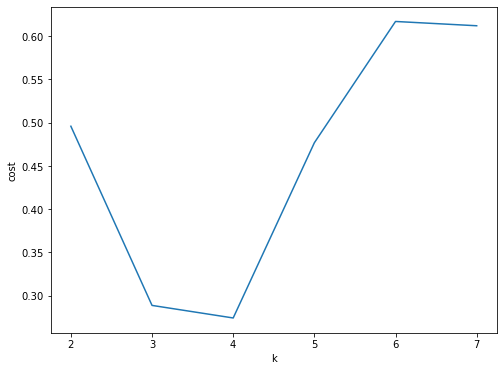

In [8]:
predictions = reg_kmeans(small_sample, 2, 8)

In [9]:
labels_clusters = predictions[2].select(['label', 'prediction'])

Total data: 210991 - Data in K0: 24708
Cluster data assigned to K0 as % of total data: 11.71045210459214%
benign : 35
syn : 24673



Total data: 210991 - Data in K1: 38412
Cluster data assigned to K1 as % of total data: 18.205515875084718%
benign : 31
udpplain : 2
scan : 26949
syn : 11114
ack : 302
udp : 14



Total data: 210991 - Data in K2: 78658
Cluster data assigned to K2 as % of total data: 37.28026313918603%
benign : 47
udpplain : 16074
ack : 22003
udp : 40534



Total data: 210991 - Data in K3: 40708
Cluster data assigned to K3 as % of total data: 19.29371394988412%
benign : 18
udpplain : 10151
ack : 10062
udp : 20477



Total data: 210991 - Data in K4: 1620
Cluster data assigned to K4 as % of total data: 0.7678052618358129%
benign : 1620



Total data: 210991 - Data in K5: 26885
Cluster data assigned to K5 as % of total data: 12.74224966941718%
benign : 26025
udpplain : 4
scan : 112
syn : 738
ack : 5
udp : 1





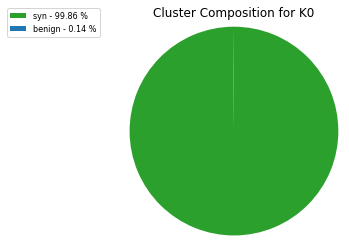

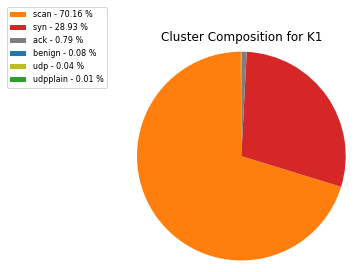

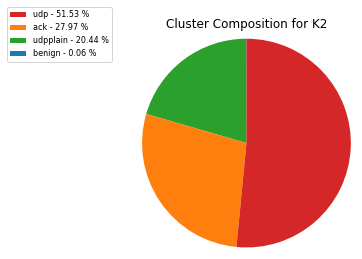

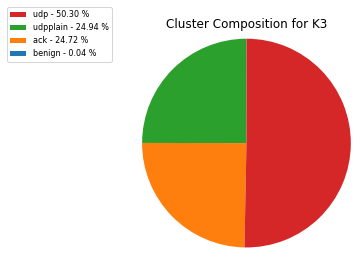

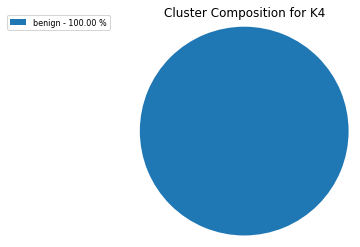

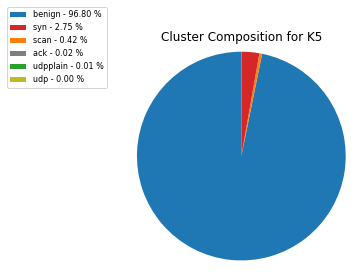

In [45]:
for i in range(predictions[1]):
    cluster = labels_clusters.filter(labels_clusters['prediction'] == i).groupBy('label').count().collect()
    assigned = sum([l[1] for l in cluster])
    total = small_sample.count()
    print(f'Total data: {total} - Data in K{i}: {assigned}')
    print(f'Cluster data assigned to K{i} as % of total data: {(assigned/total)*100}%')
    for x in cluster:
        print(f'{x[0]} : {x[1]}')
    pie(cluster, i)
    print('\n\n')

In [11]:
# print(predictions[3])